In [40]:
import os
import time
import tqdm
import numpy as np
import torch
import torch.nn.functional as F
from torch import optim

from utils.configs import Configs, model_dict
from data_provider.data_factory import data_provider
from utils.tools import EarlyStopping, adjust_learning_rate
from utils.gumbel_sigmoid import gumbel_sigmoid, budget_violation, l1_sparsity, tv_temporal, binary_entropy


In [41]:
# Define the PostProcessingNet class
class PostProcessingNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PostProcessingNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.bn1 = torch.nn.InstanceNorm1d(hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = torch.nn.InstanceNorm1d(hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, action_dim)
        

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.fc3(x)
        return gumbel_sigmoid(x, tau=1, hard=False, threshold=0.5)

In [42]:
args = Configs(data='ELC', root_path='/nfs/daojun/Data/TS_Small/')
print("load model ...")
path = os.path.join('./checkpoints/' + args.setting, 'checkpoint.pth')
print(path)
device = torch.device('cuda:0' if args.use_gpu else 'cpu')
model = model_dict[args.model].Model(args).float().to(device)
model.load_state_dict(torch.load(path))
model.eval()

load model ...
./checkpoints/ELC_96_96_iTransformer_custom_S_ft96_sl48_ll96_pl512_dm8_nh2_el1_dl2048_df1_fctimeF_ebTrue_dttest_projection_0/checkpoint.pth


Model(
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=96, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=512, out_features=512, bias=True)
          (key_projection): Linear(in_features=512, out_features=512, bias=True)
          (value_projection): Linear(in_features=512, out_features=512, bias=True)
          (out_projection): Linear(in_features=512, out_features=512, bias=True)
        )
        (conv1): Conv1d(512, 2048, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(2048, 512, kernel_size=(1,), stride=(1,))
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwi

In [43]:
post_net = PostProcessingNet(args.seq_len * args.enc_in, 
                                        args.d_model, args.seq_len * args.enc_in).to(device)
post_optim = torch.optim.Adam(post_net.parameters(), lr=args.post_train_lr)
criterion = torch.nn.MSELoss()

_, vali_loader = data_provider(args, 'val')
_, train_loader = data_provider(args, 'train')
_, test_loader = data_provider(args, 'test')

val 2537
train 18221
test 5165


In [44]:
def vali_post(data_loader, post_net=None, kappa=None):
    total_loss = []
    mae_loss = []
    model.eval()
    if post_net is not None:
        post_net.eval()
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(data_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            f_dim = -1 if args.features == 'MS' else 0
            batch_y = batch_y[:, -args.pred_len:, f_dim:]
            
            if 'PEMS' in args.data or 'Solar' in args.data:
                batch_x_mark = None
                batch_y_mark = None
            else:
                batch_x_mark = batch_x_mark.float().to(device)
                batch_y_mark = batch_y_mark.float().to(device)

            if post_net is not None:
                x_state = batch_x.view(batch_x.shape[0],-1)
                mask = post_net(x_state)
                if kappa is None:
                    mask = mask.view(*batch_x.shape) 
                else:
                    mask = mask > kappa
                    mask = mask.view(*batch_x.shape).float()

                batch_x = batch_x * mask
            
            outputs = model(batch_x, batch_x_mark, batch_y, batch_y_mark)
            
            pred = outputs.detach().cpu()
            true = batch_y.detach().cpu()

            loss = criterion(pred, true)
            mae = F.l1_loss(pred, true)
            mae_loss.append(mae)

            total_loss.append(loss)
    total_loss = np.average(total_loss)
    mae_loss = np.average(mae_loss)
    if post_net is not None: post_net.train()
    return total_loss, mae_loss

In [45]:
test_loss, mae_loss = vali_post(test_loader)
print('test_loss=%.4f' % test_loss,  'mae_loss=%.4f' % mae_loss)

test_loss=0.2659 mae_loss=0.3721


In [46]:
### trainging to get the valid mask
def post_train(post_net, kappa=0.9, vali_set = False, lambda_budget = 1, lambda_l1 = 1e-3, lambda_entropy = 1e-3,
    lambda_tv = 0):
        
    early_stopping = EarlyStopping(patience=args.patience, verbose=True)
    for episode in range(args.num_episodes):
        loss_list = []
        # with tqdm(total=len(train_loader), desc='Iteration %d' % episode) as pbar:
        for step, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float()
            batch_x_mark = batch_x_mark.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)

            f_dim = -1 if args.features == 'MS' else 0
            batch_y = batch_y[:, -args.pred_len:, f_dim:].to(device)
            
            x_state = batch_x.view(batch_x.shape[0],-1)
            mask = post_net(x_state)
            batch_x = batch_x * mask.view(*batch_x.shape)
            
            outputs = model(batch_x, batch_x_mark, batch_y, batch_y_mark)

            # regularizers
            reg_loss = 0.0
            if lambda_l1 > 0:        
                reg_loss = reg_loss + lambda_l1 * l1_sparsity(mask)
            if lambda_entropy > 0:   
                reg_loss = reg_loss + lambda_entropy * binary_entropy(mask)
            if lambda_tv > 0:        
                reg_loss = reg_loss + lambda_tv * tv_temporal(mask)
            if kappa>0:
                reg_loss = reg_loss + lambda_budget * budget_violation(mask, kappa=kappa)

            loss = criterion(outputs, batch_y) + reg_loss
            loss_list.append(loss.item())
            loss.backward()
            post_optim.step()

            if (step+1) % 100 == 0:
                print({'step': '%d' % (step+1), 'loss': '%.4f' % np.mean(loss_list)})
                # pbar.set_postfix({'step': '%d' % (step+1), 'loss': '%.4f' % np.mean(loss_list)})
            # pbar.update(1)

        if not vali_set:
            val_loss, mae_loss = vali_post(vali_loader, post_net)
            print('val_loss=%.4f' % val_loss, 'mae_loss=%.4f' % mae_loss)
            
            path = os.path.join(args.checkpoints, args.setting) 
            early_stopping(val_loss, post_net, path, name='ckpt_mask__{}.pth'.format(kappa))
            if early_stopping.early_stop:
                print("Early stopping")
                break   
                
        test_loss, mae_loss = vali_post(test_loader, post_net)
        print('test_loss=%.4f' % test_loss,  'mae_loss=%.4f' % mae_loss)

        adjust_learning_rate(post_optim, episode + 1, args)
        
    return test_loss

In [47]:
kappa = 0.9
vali_set=False
test_loss = post_train(post_net, kappa = kappa, vali_set=vali_set)

{'step': '100', 'loss': '0.1908'}
{'step': '200', 'loss': '0.1840'}
{'step': '300', 'loss': '0.1777'}
{'step': '400', 'loss': '0.1718'}
{'step': '500', 'loss': '0.1695'}
val_loss=0.2190 mae_loss=0.3166
Validation loss decreased (inf --> 0.219024).  Saving model ...
test_loss=0.2663 mae_loss=0.3703
Updating learning rate to 0.0001
{'step': '100', 'loss': '0.1637'}
{'step': '200', 'loss': '0.1614'}
{'step': '300', 'loss': '0.1607'}
{'step': '400', 'loss': '0.1586'}
{'step': '500', 'loss': '0.1588'}
val_loss=0.2198 mae_loss=0.3169
EarlyStopping counter: 1 out of 3
test_loss=0.2667 mae_loss=0.3698
Updating learning rate to 5e-05
{'step': '100', 'loss': '0.1590'}
{'step': '200', 'loss': '0.1584'}
{'step': '300', 'loss': '0.1581'}
{'step': '400', 'loss': '0.1571'}
{'step': '500', 'loss': '0.1579'}
val_loss=0.2185 mae_loss=0.3163
Validation loss decreased (0.219024 --> 0.218529).  Saving model ...
test_loss=0.2674 mae_loss=0.3704
Updating learning rate to 2.5e-05
{'step': '100', 'loss': '0.15

In [48]:
post_net.load_state_dict(torch.load(os.path.join('./checkpoints/' + args.setting, 'ckpt_mask__{}.pth'.format(kappa))))

<All keys matched successfully>

In [49]:
test_loss, mae_loss = vali_post(test_loader, post_net)
print('test_loss=%.4f' % test_loss,  'mae_loss=%.4f' % mae_loss)

test_loss, mae_loss = vali_post(test_loader, post_net, kappa)
print('test_loss=%.4f' % test_loss,  'mae_loss=%.4f' % mae_loss)


test_loss=0.2666 mae_loss=0.3695
test_loss=0.2715 mae_loss=0.3723


In [50]:
%matplotlib inline  
import matplotlib.pyplot as plt


In [60]:
def vis_sample_with_mask(post_net, visual=True):
    model.eval()
    post_net.eval()
    total_loss = []
    mae_loss = []
    indexes = [0, 23, 29, 56, 120, 280,300, 405, 468, 484]
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
            if i not in indexes:
                continue
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            f_dim = -1 if args.features == 'MS' else 0
            batch_y = batch_y[:, -args.pred_len:, f_dim:]
            
            if 'PEMS' in args.data or 'Solar' in args.data:
                batch_x_mark = None
                batch_y_mark = None
            else:
                batch_x_mark = batch_x_mark.float().to(device)
                batch_y_mark = batch_y_mark.float().to(device)

            oringin_out = model(batch_x, batch_x_mark, batch_y, batch_y_mark)

            x_state = batch_x.view(batch_x.shape[0],-1)
            mask = post_net(x_state)
            mask = mask > 0.5
            mask = mask.view(*batch_x.shape) 
            masked_x = batch_x * mask.float()
            
            masked_out = model(masked_x,  batch_x_mark, batch_y, batch_y_mark)
            
            if visual :# and i% np.random.randint(23,160)==0
                vis_true = torch.cat((batch_x, batch_y),1).squeeze(-1).detach().cpu().numpy()
                vis_pred = torch.cat((batch_x, oringin_out),1).squeeze(-1).detach().cpu().numpy()
                vis_masked = torch.cat((masked_x, masked_out),1).squeeze(-1).detach().cpu().numpy()
                masked_x = masked_x[0].squeeze(-1).detach().cpu().numpy()
                print(i,vis_true.shape, vis_pred.shape, vis_masked.shape, masked_x.shape,'xx')
                
                non_zero_indices = np.nonzero(masked_x == 0)[0]
                non_zero_values = batch_x[0,non_zero_indices,0].detach().cpu().numpy()
                plt.rcParams.update({"font.size":18})
                plt.plot(vis_true[0], label='Truth')
                plt.plot(vis_pred[0],label='Prediction')
                plt.plot(vis_pred[0,:96],color='gray')
                vis_masked = vis_masked[0]
                vis_masked[vis_masked==0] = np.nan
                plt.plot(vis_masked[:96],label='IMP Features', color='red')
                # plt.scatter(non_zero_indices,non_zero_values,label='masked points')
                plt.legend()
                plt.show()
                #if i > 96*5: break
            else:
                pred = masked_out.detach().cpu()
                true = batch_y.detach().cpu()

                loss = criterion(pred, true)
                mae = F.l1_loss(pred, true)
                mae_loss.append(mae)

                total_loss.append(loss)
    if not visual:
        total_loss = np.average(total_loss)
        mae_loss = np.average(mae_loss)
        if post_net is not None: post_net.train()
        return total_loss, mae_loss

In [52]:
test_loss, mae_loss = vis_sample_with_mask(post_net=post_net, visual=False)
print('test_loss=%.4f' % test_loss,  'mae_loss=%.4f' % mae_loss)

test_loss=0.4199 mae_loss=0.4935


0 (1, 192) (1, 192) (1, 192) (96,) xx


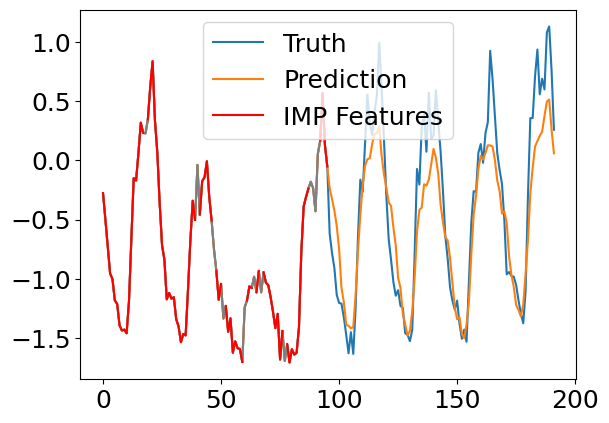

23 (1, 192) (1, 192) (1, 192) (96,) xx


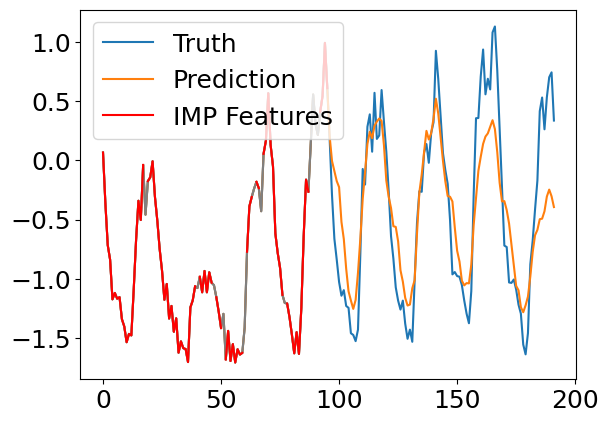

29 (1, 192) (1, 192) (1, 192) (96,) xx


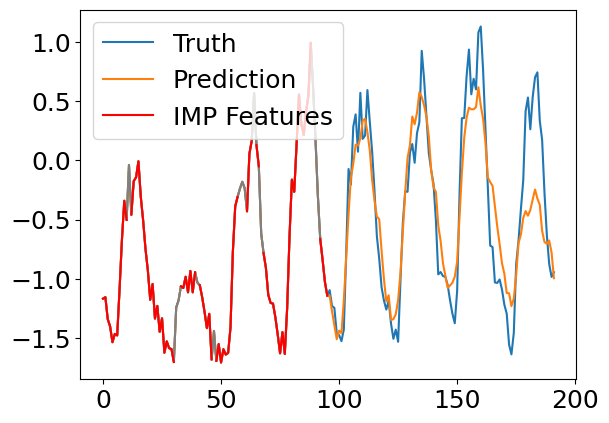

56 (1, 192) (1, 192) (1, 192) (96,) xx


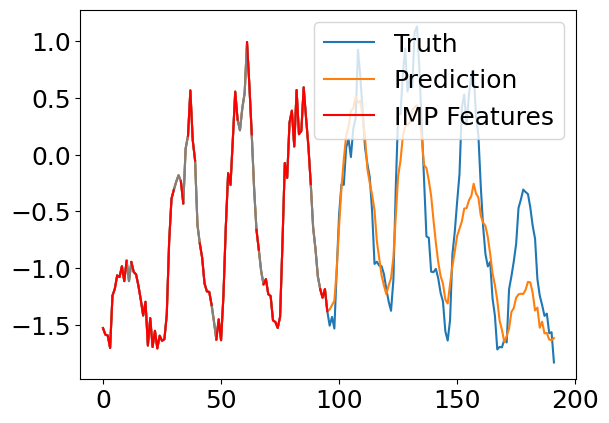

120 (1, 192) (1, 192) (1, 192) (96,) xx


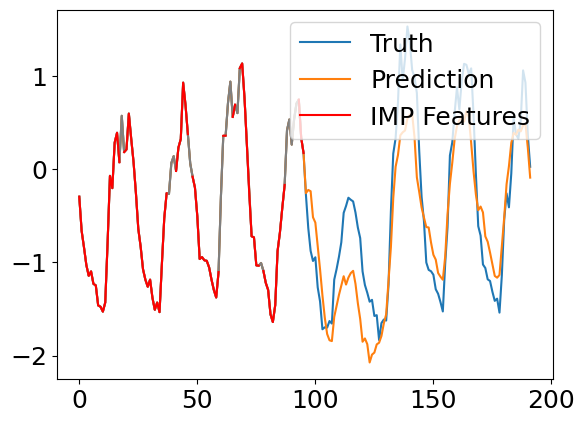

280 (1, 192) (1, 192) (1, 192) (96,) xx


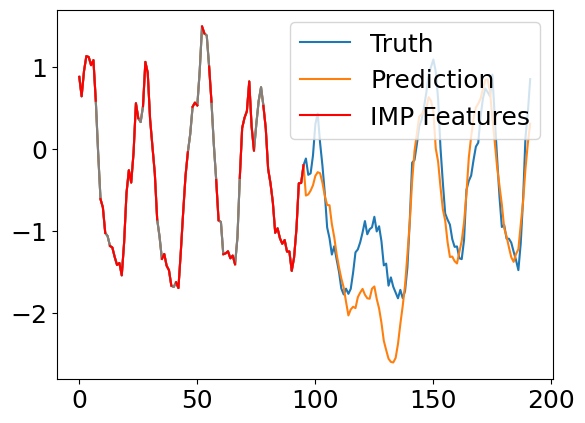

300 (1, 192) (1, 192) (1, 192) (96,) xx


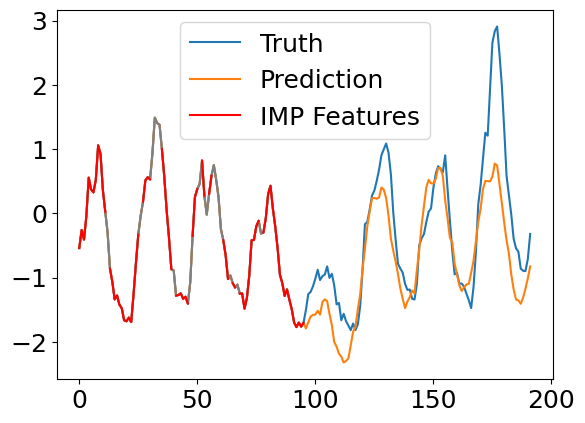

405 (1, 192) (1, 192) (1, 192) (96,) xx


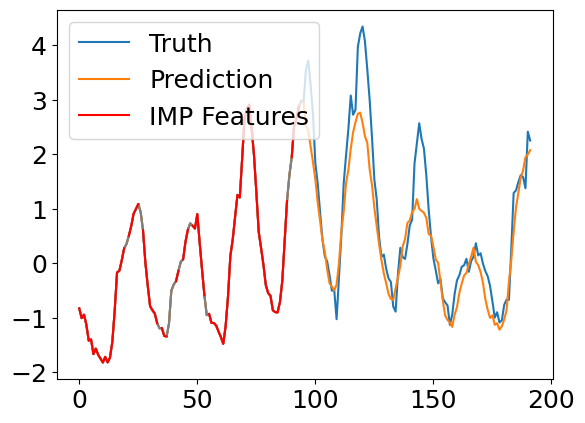

468 (1, 192) (1, 192) (1, 192) (96,) xx


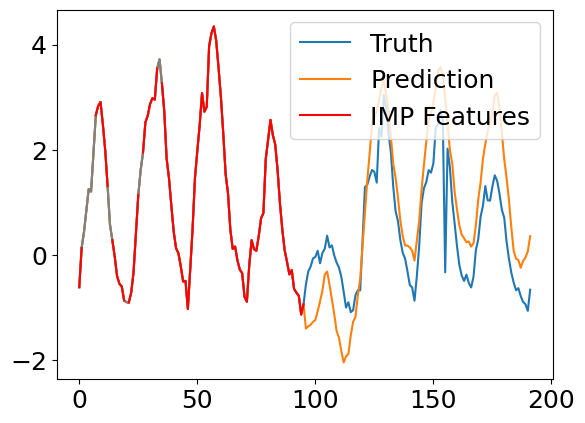

484 (1, 192) (1, 192) (1, 192) (96,) xx


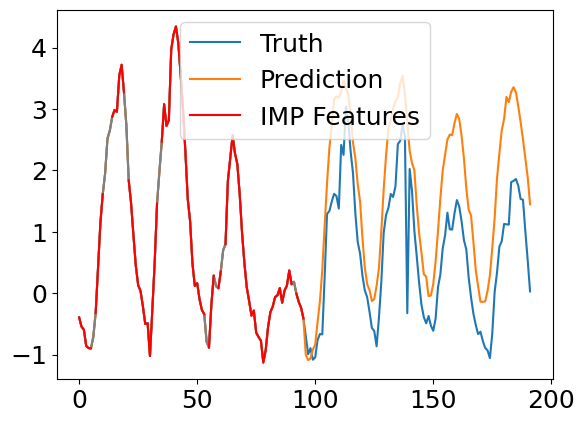

In [61]:
vis_sample_with_mask(post_net=post_net)

In [54]:
kappa = 0.5
vali_set=False
post_net_05 = PostProcessingNet(args.seq_len * args.enc_in, 
                                        args.d_model, args.seq_len * args.enc_in).to(device)
post_optim = torch.optim.Adam(post_net_05.parameters(), lr=args.post_train_lr)
test_loss = post_train(post_net_05, kappa = kappa, vali_set=vali_set)

{'step': '100', 'loss': '0.2820'}
{'step': '200', 'loss': '0.2669'}
{'step': '300', 'loss': '0.2526'}
{'step': '400', 'loss': '0.2448'}
{'step': '500', 'loss': '0.2381'}
val_loss=0.2648 mae_loss=0.3697
Validation loss decreased (inf --> 0.264846).  Saving model ...
test_loss=0.3062 mae_loss=0.3969
Updating learning rate to 0.0001
{'step': '100', 'loss': '0.2094'}
{'step': '200', 'loss': '0.2081'}
{'step': '300', 'loss': '0.2075'}
{'step': '400', 'loss': '0.2071'}
{'step': '500', 'loss': '0.2062'}
val_loss=0.2540 mae_loss=0.3560
Validation loss decreased (0.264846 --> 0.253986).  Saving model ...
test_loss=0.2937 mae_loss=0.3883
Updating learning rate to 5e-05
{'step': '100', 'loss': '0.1981'}
{'step': '200', 'loss': '0.1976'}
{'step': '300', 'loss': '0.2003'}
{'step': '400', 'loss': '0.2007'}
{'step': '500', 'loss': '0.2009'}
val_loss=0.2510 mae_loss=0.3550
Validation loss decreased (0.253986 --> 0.250952).  Saving model ...
test_loss=0.2967 mae_loss=0.3911
Updating learning rate to 2.

0 (1, 192) (1, 192) (1, 192) (96,) xx


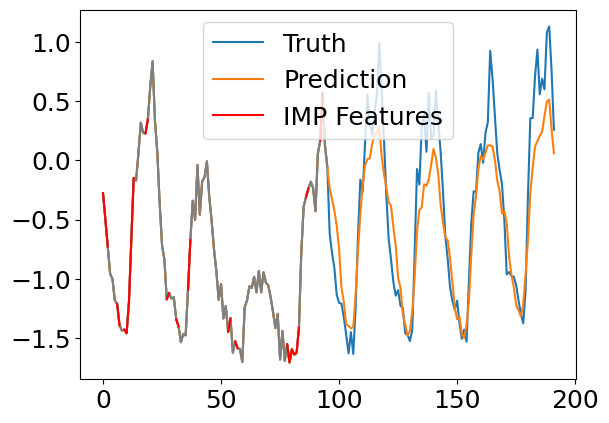

23 (1, 192) (1, 192) (1, 192) (96,) xx


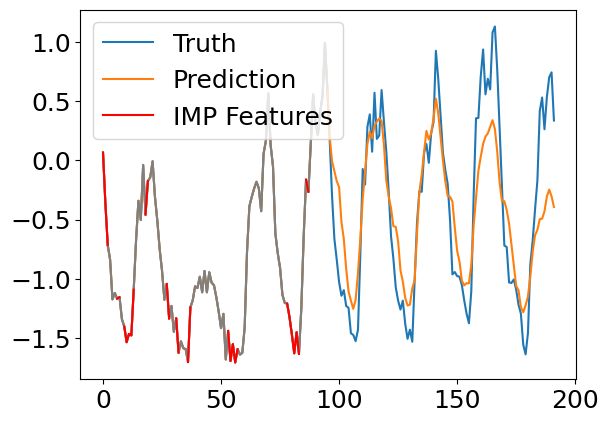

29 (1, 192) (1, 192) (1, 192) (96,) xx


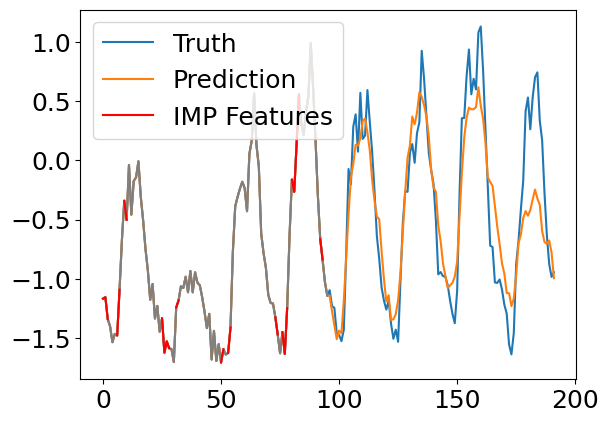

56 (1, 192) (1, 192) (1, 192) (96,) xx


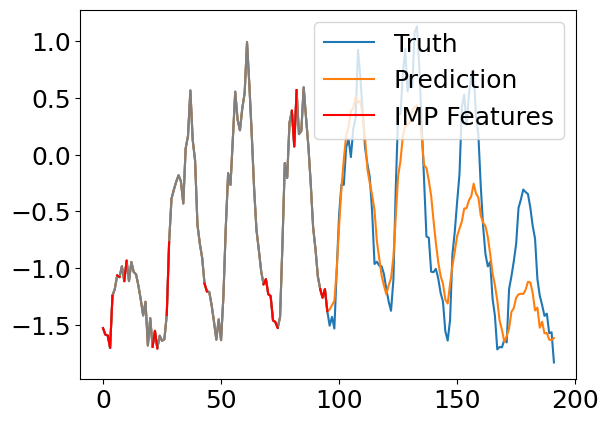

120 (1, 192) (1, 192) (1, 192) (96,) xx


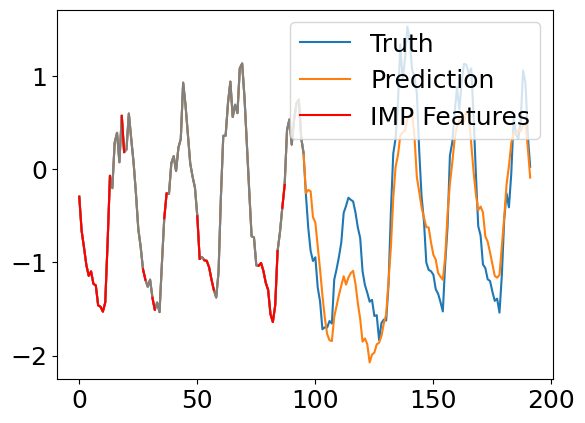

280 (1, 192) (1, 192) (1, 192) (96,) xx


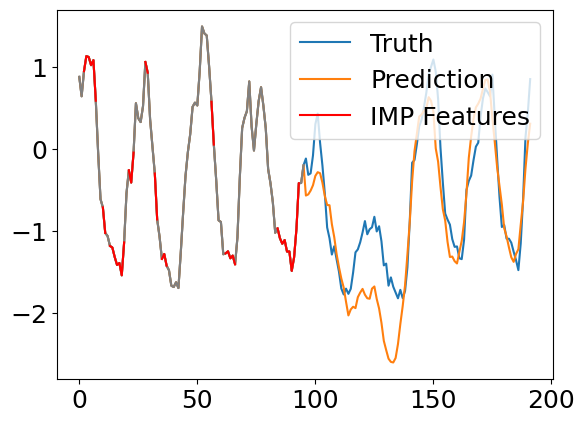

300 (1, 192) (1, 192) (1, 192) (96,) xx


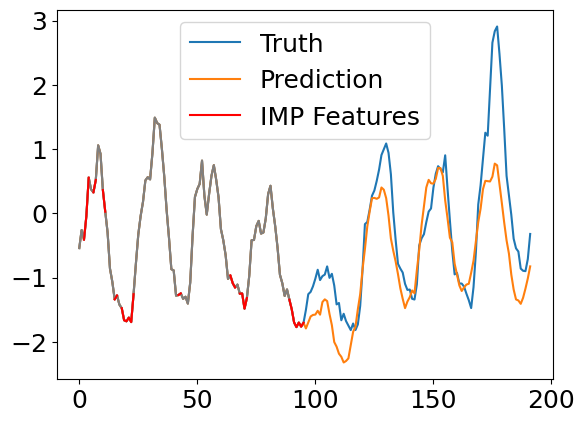

405 (1, 192) (1, 192) (1, 192) (96,) xx


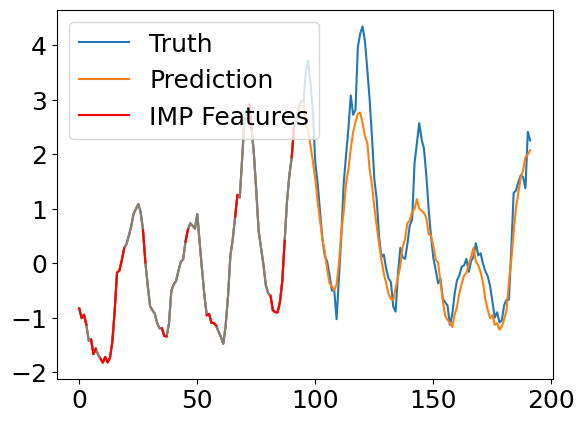

468 (1, 192) (1, 192) (1, 192) (96,) xx


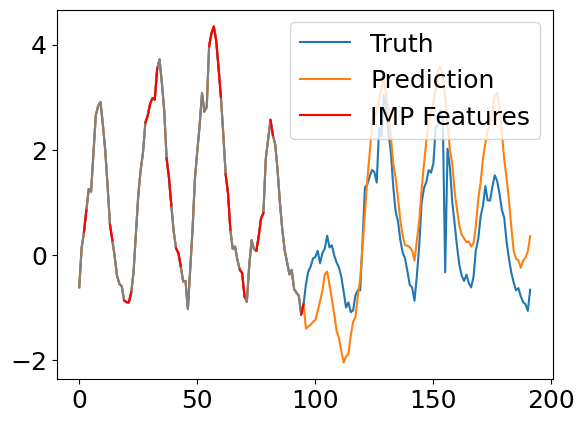

484 (1, 192) (1, 192) (1, 192) (96,) xx


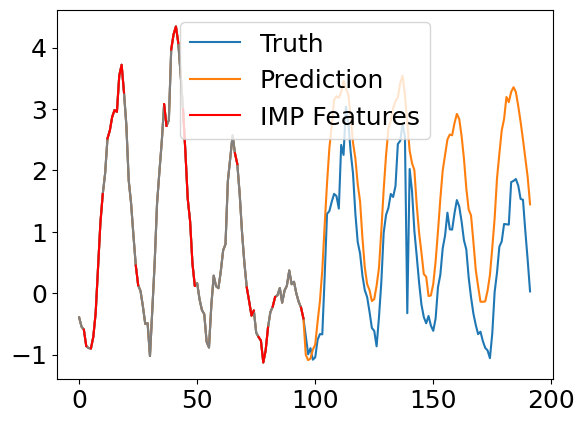

In [62]:
vis_sample_with_mask(post_net=post_net_05)

In [56]:
kappa = 0.1
vali_set=False
post_net_01 = PostProcessingNet(args.seq_len * args.enc_in, 
                                        args.d_model, args.seq_len * args.enc_in).to(device)
post_optim = torch.optim.Adam(post_net_01.parameters(), lr=args.post_train_lr)
test_loss = post_train(post_net_01, kappa = kappa, vali_set=vali_set)

{'step': '100', 'loss': '0.6314'}
{'step': '200', 'loss': '0.5745'}
{'step': '300', 'loss': '0.5467'}
{'step': '400', 'loss': '0.5213'}
{'step': '500', 'loss': '0.5046'}
val_loss=0.5037 mae_loss=0.5735
Validation loss decreased (inf --> 0.503712).  Saving model ...
test_loss=0.4851 mae_loss=0.5429
Updating learning rate to 0.0001
{'step': '100', 'loss': '0.4214'}
{'step': '200', 'loss': '0.4198'}
{'step': '300', 'loss': '0.4201'}
{'step': '400', 'loss': '0.4140'}
{'step': '500', 'loss': '0.4132'}
val_loss=0.4655 mae_loss=0.5470
Validation loss decreased (0.503712 --> 0.465549).  Saving model ...
test_loss=0.4671 mae_loss=0.5299
Updating learning rate to 5e-05
{'step': '100', 'loss': '0.4005'}
{'step': '200', 'loss': '0.3972'}
{'step': '300', 'loss': '0.3953'}
{'step': '400', 'loss': '0.3952'}
{'step': '500', 'loss': '0.3945'}
val_loss=0.4523 mae_loss=0.5373
Validation loss decreased (0.465549 --> 0.452326).  Saving model ...
test_loss=0.4566 mae_loss=0.5229
Updating learning rate to 2.

0 (1, 192) (1, 192) (1, 192) (96,) xx


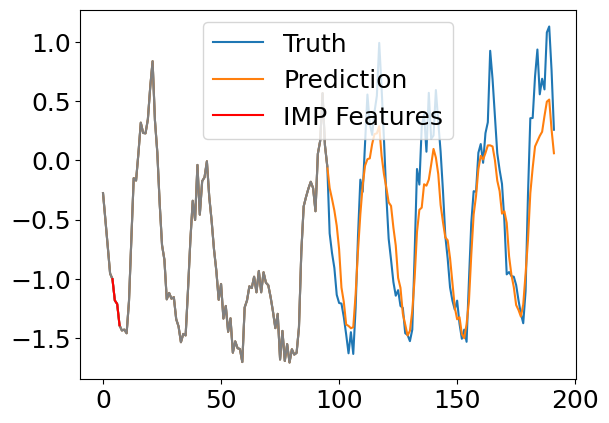

23 (1, 192) (1, 192) (1, 192) (96,) xx


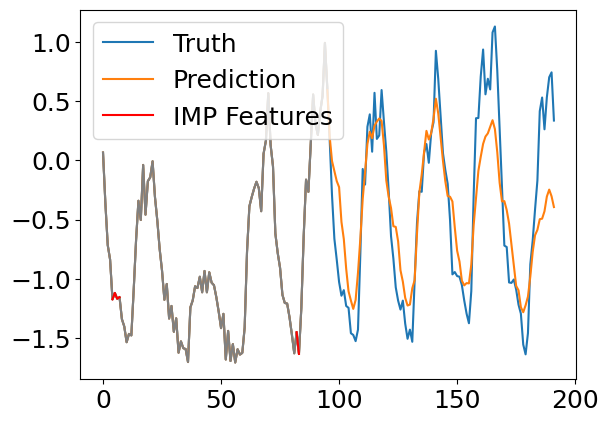

29 (1, 192) (1, 192) (1, 192) (96,) xx


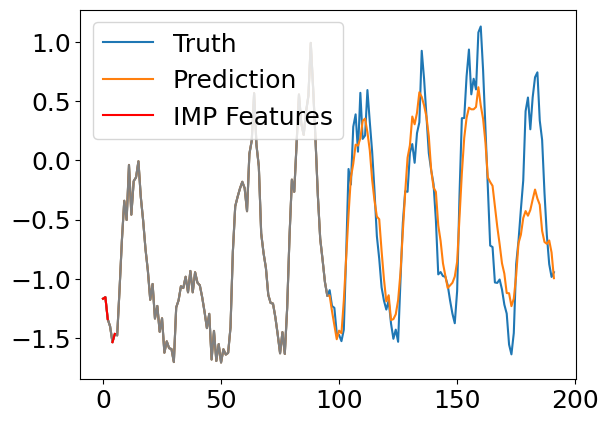

56 (1, 192) (1, 192) (1, 192) (96,) xx


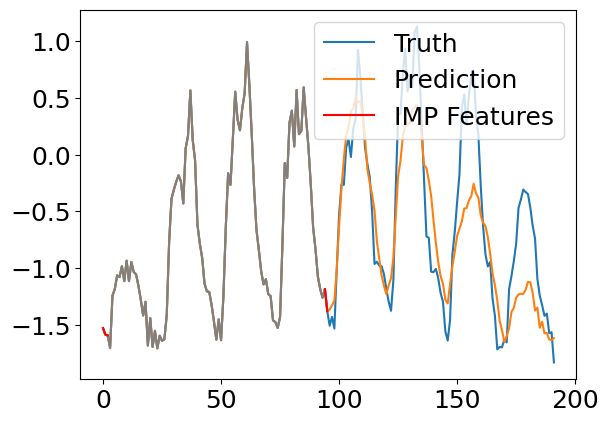

120 (1, 192) (1, 192) (1, 192) (96,) xx


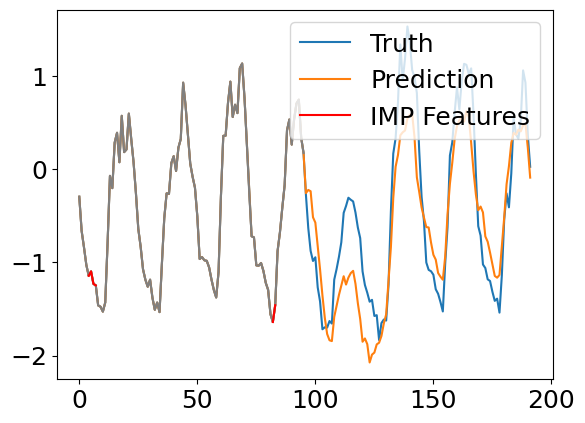

280 (1, 192) (1, 192) (1, 192) (96,) xx


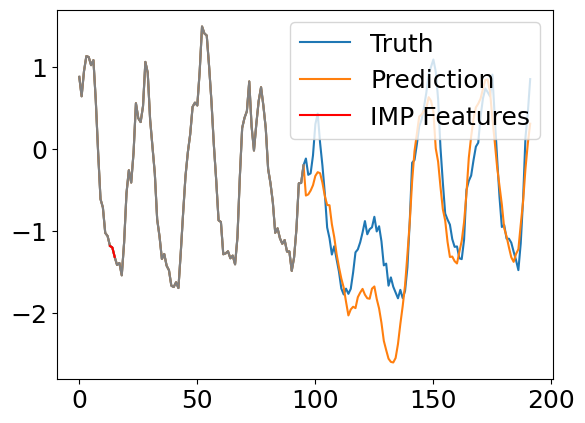

300 (1, 192) (1, 192) (1, 192) (96,) xx


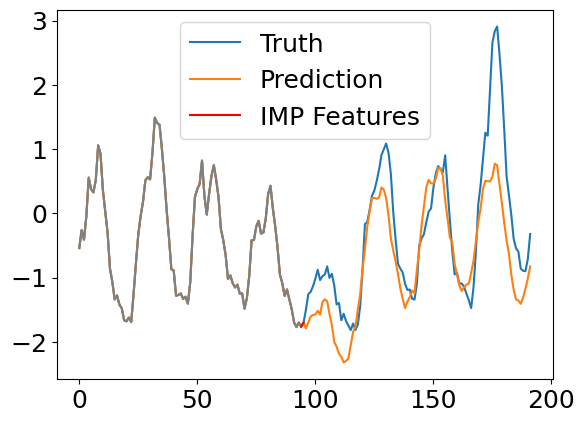

405 (1, 192) (1, 192) (1, 192) (96,) xx


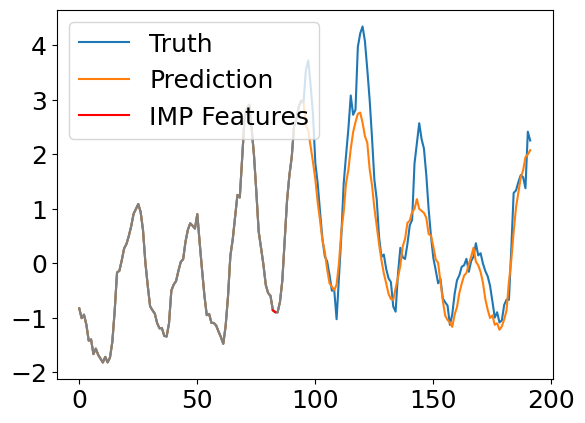

468 (1, 192) (1, 192) (1, 192) (96,) xx


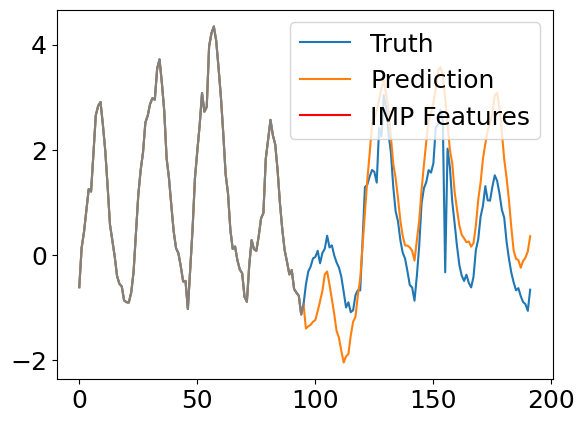

484 (1, 192) (1, 192) (1, 192) (96,) xx


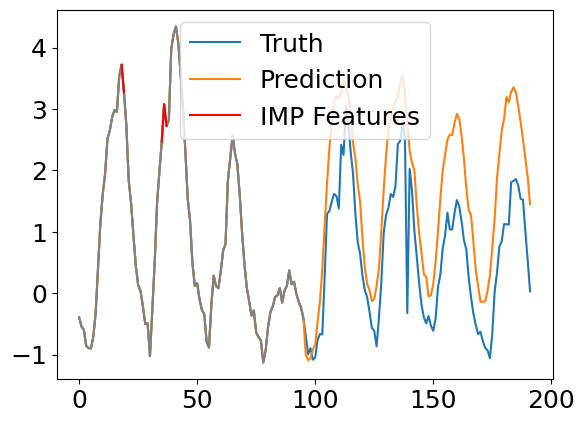

In [63]:
vis_sample_with_mask(post_net=post_net_01)

In [64]:
kappa = 0.3
vali_set=False
post_net_03 = PostProcessingNet(args.seq_len * args.enc_in, 
                                        args.d_model, args.seq_len * args.enc_in).to(device)
post_optim = torch.optim.Adam(post_net_03.parameters(), lr=args.post_train_lr)
test_loss = post_train(post_net_03, kappa = kappa, vali_set=vali_set)

{'step': '100', 'loss': '0.4467'}
{'step': '200', 'loss': '0.3990'}
{'step': '300', 'loss': '0.3710'}
{'step': '400', 'loss': '0.3517'}
{'step': '500', 'loss': '0.3391'}
val_loss=0.3555 mae_loss=0.4547
Validation loss decreased (inf --> 0.355495).  Saving model ...
test_loss=0.3732 mae_loss=0.4523
Updating learning rate to 0.0001
{'step': '100', 'loss': '0.2780'}
{'step': '200', 'loss': '0.2761'}
{'step': '300', 'loss': '0.2727'}
{'step': '400', 'loss': '0.2721'}
{'step': '500', 'loss': '0.2730'}
val_loss=0.3232 mae_loss=0.4287
Validation loss decreased (0.355495 --> 0.323204).  Saving model ...
test_loss=0.3526 mae_loss=0.4376
Updating learning rate to 5e-05
{'step': '100', 'loss': '0.2707'}
{'step': '200', 'loss': '0.2677'}
{'step': '300', 'loss': '0.2648'}
{'step': '400', 'loss': '0.2630'}
{'step': '500', 'loss': '0.2625'}
val_loss=0.3171 mae_loss=0.4238
Validation loss decreased (0.323204 --> 0.317079).  Saving model ...
test_loss=0.3478 mae_loss=0.4344
Updating learning rate to 2.

0 (1, 192) (1, 192) (1, 192) (96,) xx


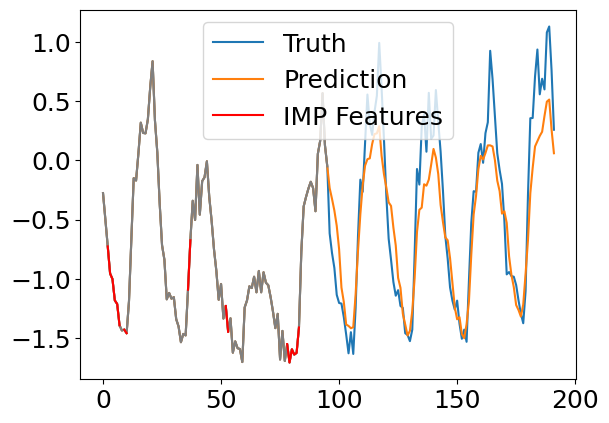

23 (1, 192) (1, 192) (1, 192) (96,) xx


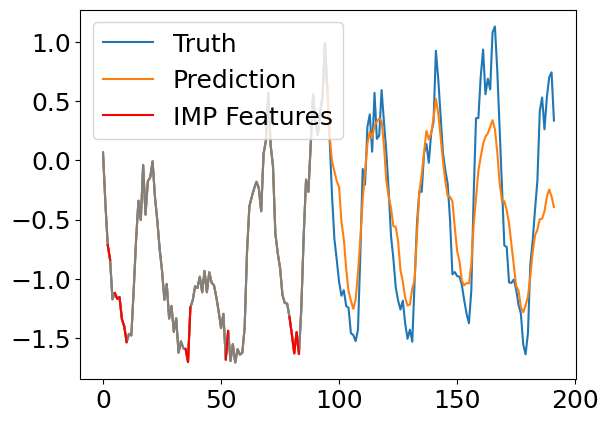

29 (1, 192) (1, 192) (1, 192) (96,) xx


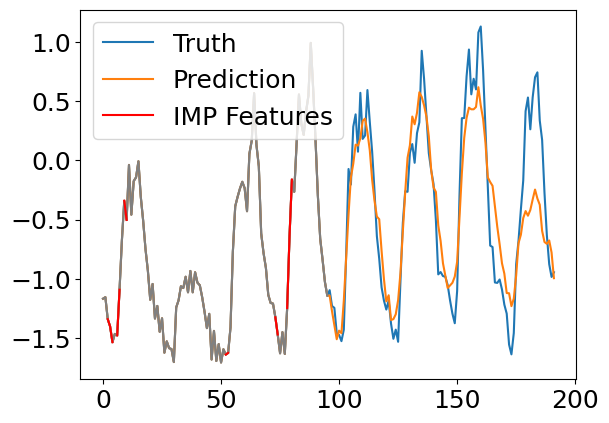

56 (1, 192) (1, 192) (1, 192) (96,) xx


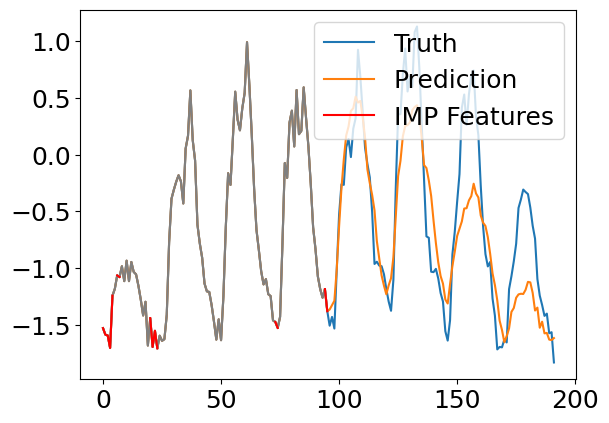

120 (1, 192) (1, 192) (1, 192) (96,) xx


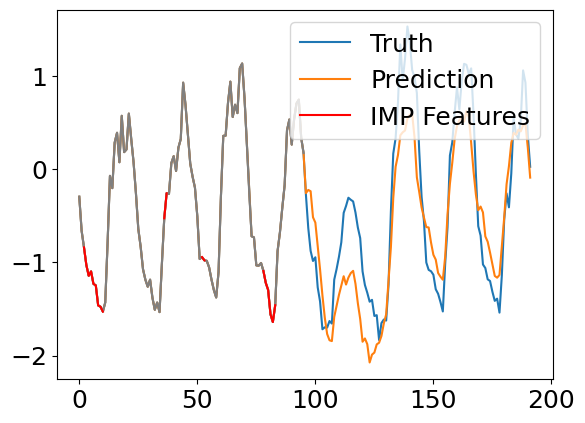

280 (1, 192) (1, 192) (1, 192) (96,) xx


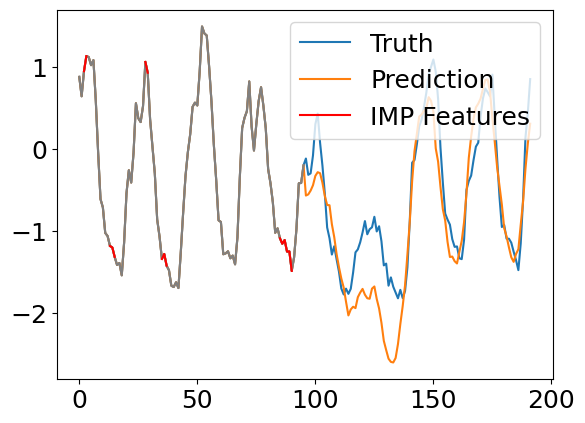

300 (1, 192) (1, 192) (1, 192) (96,) xx


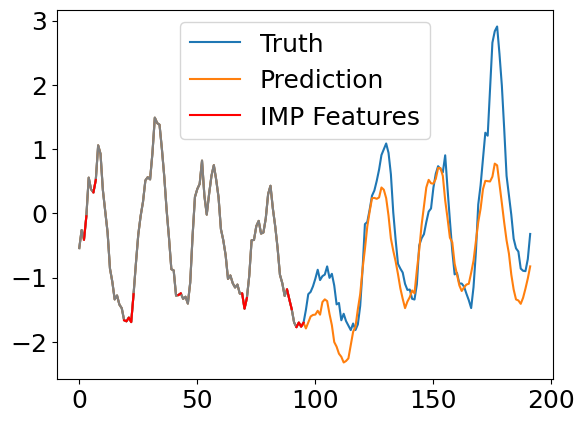

405 (1, 192) (1, 192) (1, 192) (96,) xx


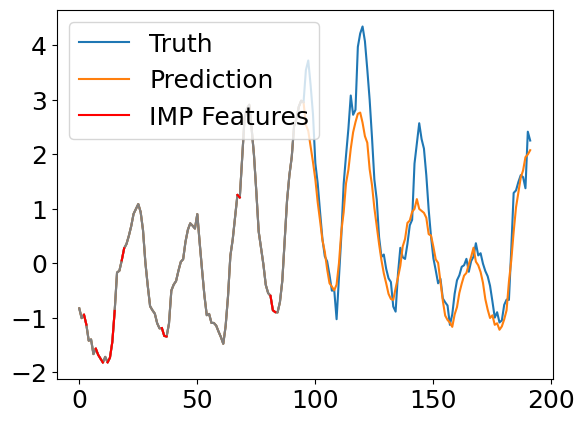

468 (1, 192) (1, 192) (1, 192) (96,) xx


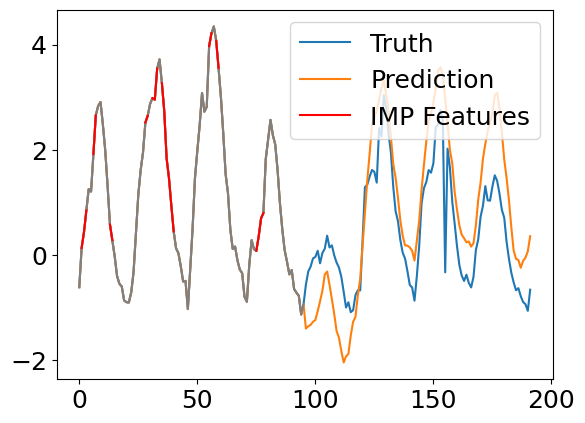

484 (1, 192) (1, 192) (1, 192) (96,) xx


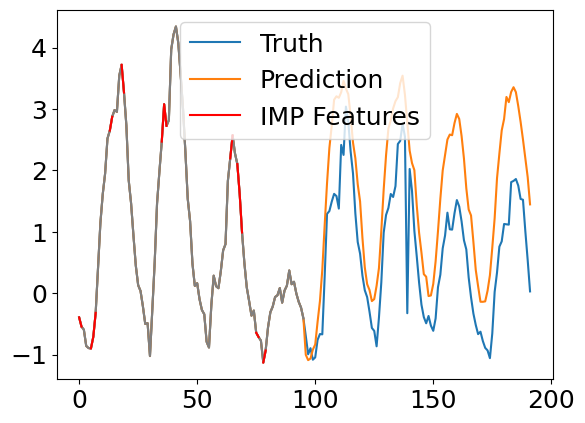

In [65]:
vis_sample_with_mask(post_net=post_net_03)